In [1]:
# -*- coding: utf-8 -*-
# =========================================================
# 강서구 펌프장 내/외수위 예측 - 멀티모델 비교 베이스라인
# =========================================================
import os, re, platform, warnings
warnings.filterwarnings("ignore")
``
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# ------------------------------
# 0) 한글 폰트 자동 패치
# ------------------------------
def patch_korean_font():
    sysname = platform.system().lower()
    font_candidates = []
    if "windows" in sysname:
        font_candidates = ["Malgun Gothic", "맑은 고딕"]
    elif "darwin" in sysname:
        font_candidates = ["AppleGothic"]
    else:
        font_candidates = ["NanumGothic", "DejaVu Sans"]
    for f in font_candidates:
        try:
            matplotlib.rcParams["font.family"] = f
            _ = plt.figure(); plt.plot([0,1],[0,1]); plt.title("폰트테스트"); plt.close()
            break
        except: continue
    matplotlib.rcParams["axes.unicode_minus"] = False

os.makedirs("figs", exist_ok=True)
patch_korean_font()

# ------------------------------
# 1) 파일 경로
# ------------------------------
PUMP_FILE   = "1.csv"
HYDRO_FILE  = "hydro_raw_2017_2025.csv"
RAIN_FILE   = "rain_2017_2024_merged.csv"
SEWER_FILE  = "sewer_2017_2024_merged.csv"

# ------------------------------
# 2) 데이터 로드 & 병합
# ------------------------------
pump = pd.read_csv(PUMP_FILE)
pump["timestamp"] = pd.to_datetime(pump["timestamp"], errors="coerce")
pump = pump.sort_values("timestamp").reset_index(drop=True)

rain = pd.read_csv(RAIN_FILE)
rain["timestamp"] = pd.to_datetime(rain["일시"], errors="coerce") if "일시" in rain.columns else pd.to_datetime(rain["timestamp"])
rain = rain.rename(columns={"강수량(mm)":"rain_mm"})[["timestamp","rain_mm"]].sort_values("timestamp")
rain["rain_mm"] = pd.to_numeric(rain["rain_mm"], errors="coerce")

hydro = pd.read_csv(HYDRO_FILE)
date_col = "관측 일시"
hour_cols = [c for c in hydro.columns if re.fullmatch(r"\s*\d{1,2}시\s*", str(c))]
hydro_long = hydro.melt(id_vars=[date_col], value_vars=hour_cols, var_name="hour_k", value_name="hydro_value")
hydro_long[date_col] = pd.to_datetime(hydro_long[date_col], errors="coerce").dt.floor("D")
hydro_long["hour_num"] = hydro_long["hour_k"].str.extract(r"(\d{1,2})").astype(int)
hydro_long["timestamp"] = hydro_long[date_col] + pd.to_timedelta(hydro_long["hour_num"]-1, unit="h")
hydro_long["hydro_value"] = pd.to_numeric(hydro_long["hydro_value"], errors="coerce")
hydro_agg = hydro_long.groupby("timestamp", as_index=False)["hydro_value"].mean()

sewer = pd.read_csv(SEWER_FILE)
sewer["timestamp"] = pd.to_datetime(sewer["timestamp"], errors="coerce")
sewer_agg = sewer.groupby("timestamp", as_index=False)["water_level"].mean()

def merge_asof_(left, right, tol="1H"):
    return pd.merge_asof(left.sort_values("timestamp"),
                         right.sort_values("timestamp"),
                         on="timestamp", direction="backward",
                         tolerance=pd.Timedelta(tol))

df = pump.copy()
df = merge_asof_(df, rain, tol="1H")
df = merge_asof_(df, hydro_agg, tol="1H")
df = merge_asof_(df, sewer_agg, tol="30min")

# 결측치 보정
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].ffill().bfill()
for c in num_cols: df[c] = df[c].fillna(df[c].median())

# ------------------------------
# 3) 파생변수 생성
# ------------------------------
def add_time_features(df, base_cols=("rain_mm","hydro_value","water_level","내수위","외수위")):
    df = df.sort_values("timestamp")
    for col in base_cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            df[f"{col}_lag1"]  = df[col].shift(1)
            df[f"{col}_lag2"]  = df[col].shift(2)
            df[f"{col}_diff1"] = df[col].diff()
            df[f"{col}_rm3"]   = df[col].rolling(3).mean()
            df[f"{col}_rm6"]   = df[col].rolling(6).mean()
    return df

df = add_time_features(df)
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())

# ------------------------------
# 4) 모델 비교 함수
# ------------------------------
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

models = {
    "Linear": Pipeline([("sc", StandardScaler()), ("m", LinearRegression())]),
    "Ridge":  Pipeline([("sc", StandardScaler()), ("m", Ridge(alpha=1.0))]),
    "Lasso":  Pipeline([("sc", StandardScaler()), ("m", Lasso(alpha=1e-3, max_iter=10000))]),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "HistGB": HistGradientBoostingRegressor(max_depth=6, learning_rate=0.08, max_iter=500, random_state=42),
}

try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
except: pass

try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(n_estimators=800, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
except: pass

try:
    from catboost import CatBoostRegressor
    models["CatBoost"] = CatBoostRegressor(iterations=800, learning_rate=0.05, depth=6, loss_function="RMSE", random_state=42, verbose=False)
except: pass

def evaluate_target(target):
    drop_cols = ["timestamp","일자","시각","펌프장 주소","위도","경도","데이터기준일자", target]
    feats = [c for c in df.columns if c not in drop_cols and df[c].dtype != "O"]
    X, y = df[feats].copy(), df[target].copy()
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]

    print(f"\n===== [Target: {target}] =====")
    results = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        oof_pred, oof_true = [], []
        for tr_idx, va_idx in kf.split(X):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            model.fit(X_tr, y_tr)
            pred = model.predict(X_va)
            oof_pred.extend(pred); oof_true.extend(y_va)

        rmse = np.sqrt(mean_squared_error(oof_true, oof_pred))
        mae  = mean_absolute_error(oof_true, oof_pred)
        r2   = r2_score(oof_true, oof_pred)
        results.append([name, rmse, mae, r2])
        print(f"{name:15s} RMSE={rmse:.3f} MAE={mae:.3f} R²={r2:.3f}")

    res_df = pd.DataFrame(results, columns=["model","RMSE","MAE","R2"]).sort_values("RMSE")
    res_df.to_csv(f"figs/compare_{target}.csv", index=False)
    return res_df

# ------------------------------
# 5) 실행
# ------------------------------
for t in ["내수위","외수위"]:
    if t in df.columns:
        evaluate_target(t)

print("\n[DONE] 모든 모델 비교 완료 → figs/compare_*.csv 확인")


SyntaxError: invalid syntax (3930963919.py, line 7)

In [2]:
# -*- coding: utf-8 -*-
# =========================================================
# 강서구 펌프장 내/외수위 예측 - E2E 멀티모델 비교 (원클릭)
#   - 입력: 1.csv, hydro_raw_2017_2025.csv, rain_2017_2024_merged.csv, sewer_2017_2024_merged.csv
#   - 출력: figs/<타겟>_<모델>_scatter.png, _importance.png, _shap_*.png, <타겟>_results.csv
# =========================================================
import os, re, platform, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# ------------------------------
# 0) 한글 폰트
# ------------------------------
def patch_korean_font():
    sysname = platform.system().lower()
    for f in (["Malgun Gothic","맑은 고딕"] if "windows" in sysname
              else ["AppleGothic"] if "darwin" in sysname
              else ["NanumGothic","DejaVu Sans"]):
        try:
            matplotlib.rcParams["font.family"] = f
            _ = plt.figure(); plt.title("폰트테스트"); plt.close()
            print(f"[INFO] 폰트 적용: {f}"); break
        except Exception: continue
    matplotlib.rcParams["axes.unicode_minus"] = False

os.makedirs("figs", exist_ok=True)
patch_korean_font()

# ------------------------------
# 1) 파일 경로 & asof tolerances
# ------------------------------
PUMP_FILE   = "1.csv"
HYDRO_FILE  = "hydro_raw_2017_2025.csv"
RAIN_FILE   = "rain_2017_2024_merged.csv"
SEWER_FILE  = "sewer_2017_2024_merged.csv"

RAIN_TOL  = "1H"
HYDRO_TOL = "1H"
SEWER_TOL = "30min"

# ------------------------------
# 2) 데이터 로드/정규화
# ------------------------------
def load_pump(path=PUMP_FILE):
    pump = pd.read_csv(path)
    if "timestamp" in pump.columns:
        pump["timestamp"] = pd.to_datetime(pump["timestamp"], errors="coerce")
    elif {"일자","시각"} <= set(pump.columns):
        ts_a = pd.to_datetime(pump["일자"], errors="coerce")
        ts_b = pd.to_datetime(pump["시각"], errors="coerce")
        pump["timestamp"] = ts_a.combine_first(ts_b)
    else:
        raise KeyError("펌프 데이터에 'timestamp' 또는 ['일자','시각']가 필요합니다.")
    return pump.sort_values("timestamp").reset_index(drop=True)

def load_rain(path=RAIN_FILE):
    rain = pd.read_csv(path)
    if "timestamp" not in rain.columns:
        if "일시" in rain.columns:
            rain["timestamp"] = pd.to_datetime(rain["일시"], errors="coerce")
        else:
            raise KeyError("강우 데이터에 'timestamp' 또는 '일시'가 필요합니다.")
    else:
        rain["timestamp"] = pd.to_datetime(rain["timestamp"], errors="coerce")
    if "강수량(mm)" in rain.columns:
        rain.rename(columns={"강수량(mm)":"rain_mm"}, inplace=True)
    if "rain_mm" not in rain.columns:
        raise KeyError("강우 데이터에 '강수량(mm)' 또는 'rain_mm' 컬럼이 필요합니다.")
    rain["rain_mm"] = pd.to_numeric(rain["rain_mm"], errors="coerce")
    return rain[["timestamp","rain_mm"]].dropna(subset=["timestamp"]).sort_values("timestamp")

def load_hydro(path=HYDRO_FILE):
    hydro = pd.read_csv(path)
    if "관측 일시" not in hydro.columns:
        raise KeyError("수문 데이터에 '관측 일시' 컬럼이 필요합니다.")
    date_col = "관측 일시"
    hour_cols = [c for c in hydro.columns if re.fullmatch(r"\s*\d{1,2}시\s*", str(c))]
    if not hour_cols:
        raise KeyError("수문 데이터에서 시간 컬럼(예: '01시'~'24시')을 찾지 못했습니다.")
    long = hydro.melt(id_vars=[date_col], value_vars=hour_cols,
                      var_name="hour_k", value_name="hydro_value")
    long[date_col] = pd.to_datetime(long[date_col], errors="coerce").dt.floor("D")
    long["hour_num"] = long["hour_k"].astype(str).str.extract(r"(\d{1,2})").astype(int)
    # 1~24시 → 0~23시(자정=0)
    long["timestamp"] = long[date_col] + pd.to_timedelta((long["hour_num"]-1) % 24, unit="h")
    long["hydro_value"] = pd.to_numeric(long["hydro_value"], errors="coerce")
    agg = (long.dropna(subset=["timestamp"])
                .groupby("timestamp", as_index=False)["hydro_value"].mean())
    return agg.sort_values("timestamp")

def load_sewer(path=SEWER_FILE):
    sewer = pd.read_csv(path)
    if not {"timestamp","water_level"} <= set(sewer.columns):
        raise KeyError("하수 데이터에 'timestamp','water_level' 필요")
    sewer["timestamp"] = pd.to_datetime(sewer["timestamp"], errors="coerce")
    sewer["water_level"] = pd.to_numeric(sewer["water_level"], errors="coerce")
    agg = sewer.groupby("timestamp", as_index=False)["water_level"].mean()
    return agg.sort_values("timestamp")

# ------------------------------
# 3) 안전 asof merge
# ------------------------------
def merge_asof_(left, right, tol="1H", on="timestamp"):
    if right is None or len(right)==0: return left
    L = left.sort_values(on).copy()
    R = right.sort_values(on).copy()
    out = pd.merge_asof(L, R, on=on, direction="backward",
                        tolerance=pd.Timedelta(tol))
    return out

# ------------------------------
# 4) 병합 & 기본 정리
# ------------------------------
pump  = load_pump()
rain  = load_rain()
hydro = load_hydro()
sewer = load_sewer()

df = pump.copy()
df = merge_asof_(df, rain,  tol=RAIN_TOL)
df = merge_asof_(df, hydro, tol=HYDRO_TOL)
df = merge_asof_(df, sewer, tol=SEWER_TOL)

# 수치형 보수(시계열 ffill→bfill→median)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].ffill().bfill()
for c in num_cols: df[c] = df[c].fillna(df[c].median())

# 문자열 컬럼 중 수치형으로 해석 가능한 것 변환
cat_cols = {"펌프장명","펌프장 주소","일자","시각"}
for c in df.columns:
    if c not in cat_cols and df[c].dtype == "O":
        df[c] = pd.to_numeric(df[c], errors="ignore")

# ------------------------------
# 5) 시계열 파생 (그룹=펌프장명, 누설 방지)
# ------------------------------
def add_time_features(_df, group_col="펌프장명",
                      base=("rain_mm","hydro_value","water_level","내수위","외수위")):
    df2 = _df.copy()
    if group_col in df2.columns:
        df2 = df2.sort_values([group_col,"timestamp"])
        g = df2.groupby(group_col, group_keys=False)
        for col in base:
            if col in df2.columns and pd.api.types.is_numeric_dtype(df2[col]):
                df2[f"{col}_lag1"]  = g[col].shift(1)
                df2[f"{col}_lag2"]  = g[col].shift(2)
                df2[f"{col}_diff1"] = g[col].diff()
                df2[f"{col}_rm3"]   = g[col].rolling(3).mean().reset_index(level=0, drop=True)
                df2[f"{col}_rm6"]   = g[col].rolling(6).mean().reset_index(level=0, drop=True)
    else:
        df2 = df2.sort_values("timestamp")
        for col in base:
            if col in df2.columns and pd.api.types.is_numeric_dtype(df2[col]):
                df2[f"{col}_lag1"]  = df2[col].shift(1)
                df2[f"{col}_lag2"]  = df2[col].shift(2)
                df2[f"{col}_diff1"] = df2[col].diff()
                df2[f"{col}_rm3"]   = df2[col].rolling(3).mean()
                df2[f"{col}_rm6"]   = df2[col].rolling(6).mean()
    # 파생 NaN 보수
    for c in df2.select_dtypes(include=[np.number]).columns:
        df2[c] = df2[c].fillna(df2[c].median())
    return df2

df = add_time_features(df)

# ------------------------------
# 6) 모델 정의
# ------------------------------
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

models = {
    "Linear": Pipeline([("sc", StandardScaler()), ("m", LinearRegression())]),
    "Ridge":  Pipeline([("sc", StandardScaler()), ("m", Ridge(alpha=1.0))]),
    "Lasso":  Pipeline([("sc", StandardScaler()), ("m", Lasso(alpha=0.001, max_iter=10000))]),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GBDT": GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42),
    "HistGB": HistGradientBoostingRegressor(max_iter=500, learning_rate=0.05, max_depth=6, random_state=42),
}

# 외부 부스팅 라이브러리(있으면 추가)
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method="hist"
    )
except Exception as e:
    print("[INFO] XGBoost 미설치 → 스킵:", e)

try:
    from lightgbm import LGBMRegressor
    models["LightGBM"] = LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
except Exception as e:
    print("[INFO] LightGBM 미설치 → 스킵:", e)

try:
    from catboost import CatBoostRegressor
    models["CatBoost"] = CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=6,
        random_state=42, loss_function="RMSE", verbose=False
    )
except Exception as e:
    print("[INFO] CatBoost 미설치 → 스킵:", e)

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------
# 7) 타깃별 학습/검증/시각화
# ------------------------------
TARGETS = [t for t in ["내수위","외수위"] if t in df.columns]
DROP = {"timestamp","일자","시각","펌프장 주소","위도","경도","데이터기준일자"}

for TARGET in TARGETS:
    print(f"\n==================== [타겟: {TARGET}] ====================")
    feat_cols = [c for c in df.columns if c not in DROP|{TARGET} and df[c].dtype != "O"]
    X = df[feat_cols].copy()
    y = df[TARGET].copy()
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]

    # GroupKFold(누설 차단) → 펌프장명 없으면 KFold
    if "펌프장명" in df.columns:
        groups = df.loc[X.index, "펌프장명"]
        splitter = GroupKFold(n_splits=5).split(X, y, groups=groups)
    else:
        splitter = KFold(n_splits=5, shuffle=True, random_state=42).split(X)

    results = []

    for name, model in models.items():
        # CV를 매 모델마다 재생성(한 번 소비하면 iterator 소진)
        if "펌프장명" in df.columns:
            splits = GroupKFold(n_splits=5).split(X, y, groups=df.loc[X.index, "펌프장명"])
        else:
            splits = KFold(n_splits=5, shuffle=True, random_state=42).split(X)

        oof_pred = np.zeros(len(y))
        for tr_idx, va_idx in splits:
            m = model  # 파이프라인/모델은 새로 생성(파라미터 동일)
            # 일부 모델은 상태가 남을 수 있어 동일 클래스로 재생성 권장
            try:
                m = model.__class__(**model.get_params())
            except Exception:
                pass
            m.fit(X.iloc[tr_idx], y.iloc[tr_idx])
            oof_pred[va_idx] = m.predict(X.iloc[va_idx])

        rmse = float(np.sqrt(mean_squared_error(y, oof_pred)))
        r2   = float(r2_score(y, oof_pred))
        results.append((name, rmse, r2))
        print(f"[{name:10s}] RMSE={rmse:.4f}  R²={r2:.5f}")

        # 회귀선 플롯 (OOF)
        plt.figure(figsize=(5.2,4.2))
        plt.scatter(y, oof_pred, s=8, alpha=0.45)
        lo, hi = float(min(y.min(), oof_pred.min())), float(max(y.max(), oof_pred.max()))
        plt.plot([lo, hi], [lo, hi], "r--", lw=1)
        k = np.polyfit(y, oof_pred, 1)
        xx = np.linspace(lo, hi, 100)
        plt.plot(xx, k[0]*xx + k[1], "g-", lw=1.2)
        plt.title(f"{TARGET} - {name} (OOF)\nRMSE={rmse:,.2f}  R²={r2:.5f}")
        plt.xlabel("실제값"); plt.ylabel("예측값")
        plt.tight_layout(); plt.savefig(f"figs/{TARGET}_{name}_scatter.png", dpi=220); plt.close()

        # 변수 중요도(트리/부스팅)
        try:
            fitted = model.__class__(**model.get_params())
            fitted.fit(X, y)
            if hasattr(fitted, "feature_importances_"):
                imp = (pd.DataFrame({"feature": feat_cols, "importance": fitted.feature_importances_})
                         .sort_values("importance", ascending=False).head(20))
                plt.figure(figsize=(8,6))
                plt.barh(imp["feature"][::-1], imp["importance"][::-1])
                plt.title(f"{TARGET} - {name} 중요 변수 Top20 (FULL)")
                plt.tight_layout(); plt.savefig(f"figs/{TARGET}_{name}_importance.png", dpi=220); plt.close()
        except Exception as e:
            print(f"[INFO] 중요도 스킵({name}):", e)

        # SHAP (가능한 모델만)
        try:
            import shap
            nsample = min(1000, len(X))
            Xs = X.sample(nsample, random_state=42)
            fitted = model.__class__(**model.get_params()); fitted.fit(X, y)
            explainer = shap.Explainer(fitted, Xs)
            sh = explainer(Xs)

            shap.summary_plot(sh, Xs, plot_type="bar", show=False, max_display=20)
            plt.title(f"{TARGET} - {name} SHAP (bar)")
            plt.tight_layout(); plt.savefig(f"figs/{TARGET}_{name}_shap_bar.png", dpi=220); plt.close()

            shap.summary_plot(sh, Xs, plot_type="dot", show=False, max_display=20)
            plt.title(f"{TARGET} - {name} SHAP (dot)")
            plt.tight_layout(); plt.savefig(f"figs/{TARGET}_{name}_shap_dot.png", dpi=220); plt.close()
        except Exception as e:
            print(f"[INFO] SHAP 스킵({name}):", e)

    # 결과 테이블
    res = pd.DataFrame(results, columns=["Model","RMSE","R2"]).sort_values("RMSE")
    print(f"\n[최종 성능 비교 - {TARGET}]")
    print(res.to_string(index=False))
    res.to_csv(f"figs/{TARGET}_results.csv", index=False)

print("\n[DONE] 전체 파이프라인 완료 → figs/ 폴더 결과 확인")


[INFO] 폰트 적용: Malgun Gothic
[INFO] CatBoost 미설치 → 스킵: No module named 'catboost'

==================== [타겟: 내수위] ====================
[Linear    ] RMSE=0.0283  R²=0.99954
[INFO] 중요도 스킵(Linear): Pipeline.__init__() got an unexpected keyword argument 'sc'
[INFO] SHAP 스킵(Linear): Pipeline.__init__() got an unexpected keyword argument 'sc'
[Ridge     ] RMSE=0.0303  R²=0.99947
[INFO] 중요도 스킵(Ridge): Pipeline.__init__() got an unexpected keyword argument 'sc'
[INFO] SHAP 스킵(Ridge): Pipeline.__init__() got an unexpected keyword argument 'sc'
[Lasso     ] RMSE=0.0171  R²=0.99983
[INFO] 중요도 스킵(Lasso): Pipeline.__init__() got an unexpected keyword argument 'sc'
[INFO] SHAP 스킵(Lasso): Pipeline.__init__() got an unexpected keyword argument 'sc'
[RandomForest] RMSE=0.2657  R²=0.95949


100%|===================| 998/1000 [01:21<00:00]        

[GBDT      ] RMSE=0.5646  R²=0.81706


 99%|===================| 987/1000 [00:13<00:00]        

[HistGB    ] RMSE=0.4907  R²=0.86181
[INFO] SHAP 스킵(HistGB): Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 4.480353, while the model output was 4.625601. If this difference is acceptable you can set check_additivity=False to disable this check.
[XGBoost   ] RMSE=0.4575  R²=0.87988


 97%|=================== | 970/1000 [00:12<00:00]       

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 29402, number of used features: 28
[LightGBM] [Info] Start training from score 1.788364
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5025
[LightGBM] [Info] Number of data points in the train set: 50786, number of used features: 28
[LightGBM] [Info] Start training from score 2.954490
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of te

 98%|===================| 976/1000 [00:13<00:00]        

[INFO] SHAP 스킵(LightGBM): Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -0.159416, while the model output was -0.122128. If this difference is acceptable you can set check_additivity=False to disable this check.

[최종 성능 비교 - 내수위]
       Model     RMSE       R2
       Lasso 0.017133 0.999832
      Linear 0.028293 0.999541
       Ridge 0.030339 0.999472
RandomForest 0.265686 0.959491
    LightGBM 0.414948 0.901190
     XGBoost 0.457513 0.879878
      HistGB 0.490722 0.861807
        GBDT 0.564606 0.817061

==================== [타겟: 외수위] ====================
[Linear    ] RMSE=0.0130  R²=0.99994
[INFO] 중요도 스킵(Linear): Pipeline.__init__() got an unexpected keyword argument 'sc'
[INFO] SHAP 스킵(Linear): Pipeline.__init__() got an unexpected keyword 

 99%|===================| 994/1000 [01:09<00:00]        

[GBDT      ] RMSE=0.1961  R²=0.98631


 95%|=================== | 947/1000 [00:15<00:00]       

[HistGB    ] RMSE=0.2482  R²=0.97807
[INFO] SHAP 스킵(HistGB): Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 9.886080, while the model output was 9.468494. If this difference is acceptable you can set check_additivity=False to disable this check.
[XGBoost   ] RMSE=0.2998  R²=0.96801


 97%|=================== | 972/1000 [00:14<00:00]       

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 29402, number of used features: 28
[LightGBM] [Info] Start training from score 4.726457
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5016
[LightGBM] [Info] Number of data points in the train set: 50786, number of used features: 28
[LightGBM] [Info] Start training from score 5.515465
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [

 97%|=================== | 968/1000 [00:15<00:00]       

[INFO] SHAP 스킵(LightGBM): Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 3.068488, while the model output was 3.016279. If this difference is acceptable you can set check_additivity=False to disable this check.

[최종 성능 비교 - 외수위]
       Model     RMSE       R2
       Ridge 0.011752 0.999951
      Linear 0.013041 0.999939
       Lasso 0.021264 0.999839
    LightGBM 0.166973 0.990078
        GBDT 0.196112 0.986313
RandomForest 0.199760 0.985799
      HistGB 0.248211 0.978075
     XGBoost 0.299802 0.968013

[DONE] 전체 파이프라인 완료 → figs/ 폴더 결과 확인


[INFO] 폰트 적용: Malgun Gothic
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 29402, number of used features: 28
[LightGBM] [Info] Start training from score 1.788364
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5025
[LightGBM] [Info] Number of data points in the train set: 50786, number of used features: 28
[LightGBM] [Info] Start training from score 2.954490
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-t

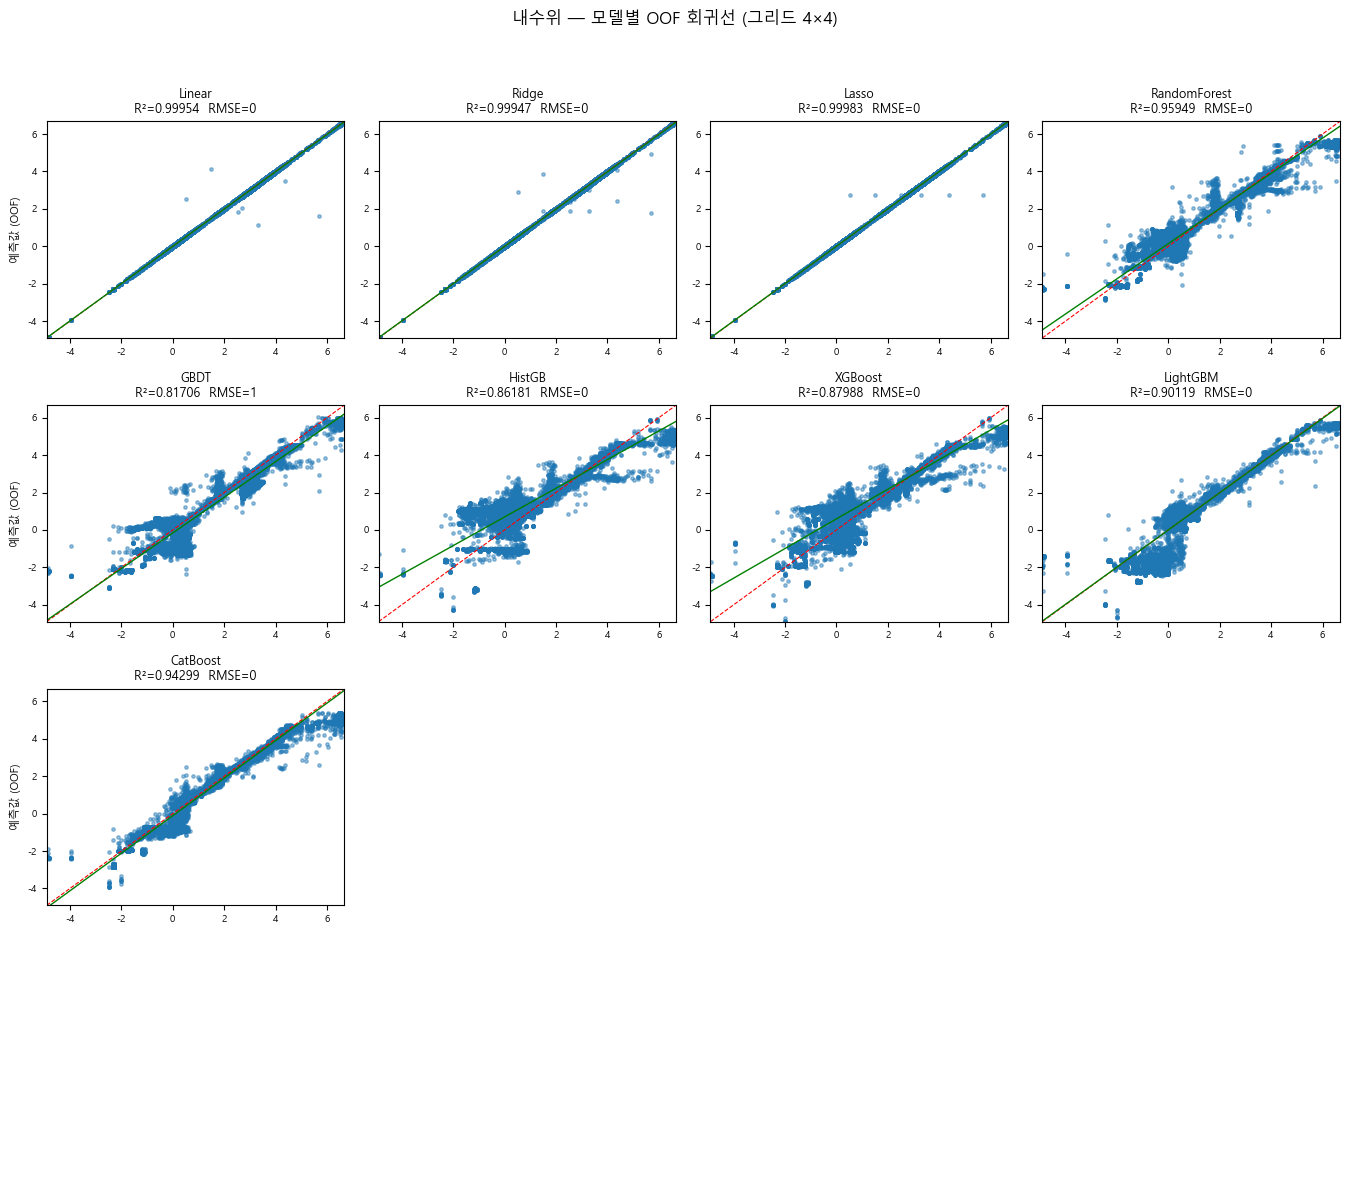


[성능 요약] 내수위
       Model     RMSE       R2
       Lasso 0.017133 0.999832
      Linear 0.028293 0.999541
       Ridge 0.030339 0.999472
RandomForest 0.265686 0.959491
    CatBoost 0.315190 0.942989
    LightGBM 0.414948 0.901190
     XGBoost 0.457513 0.879878
      HistGB 0.490722 0.861807
        GBDT 0.564606 0.817061
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 29402, number of used features: 28
[LightGBM] [Info] Start training from score 4.726457
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

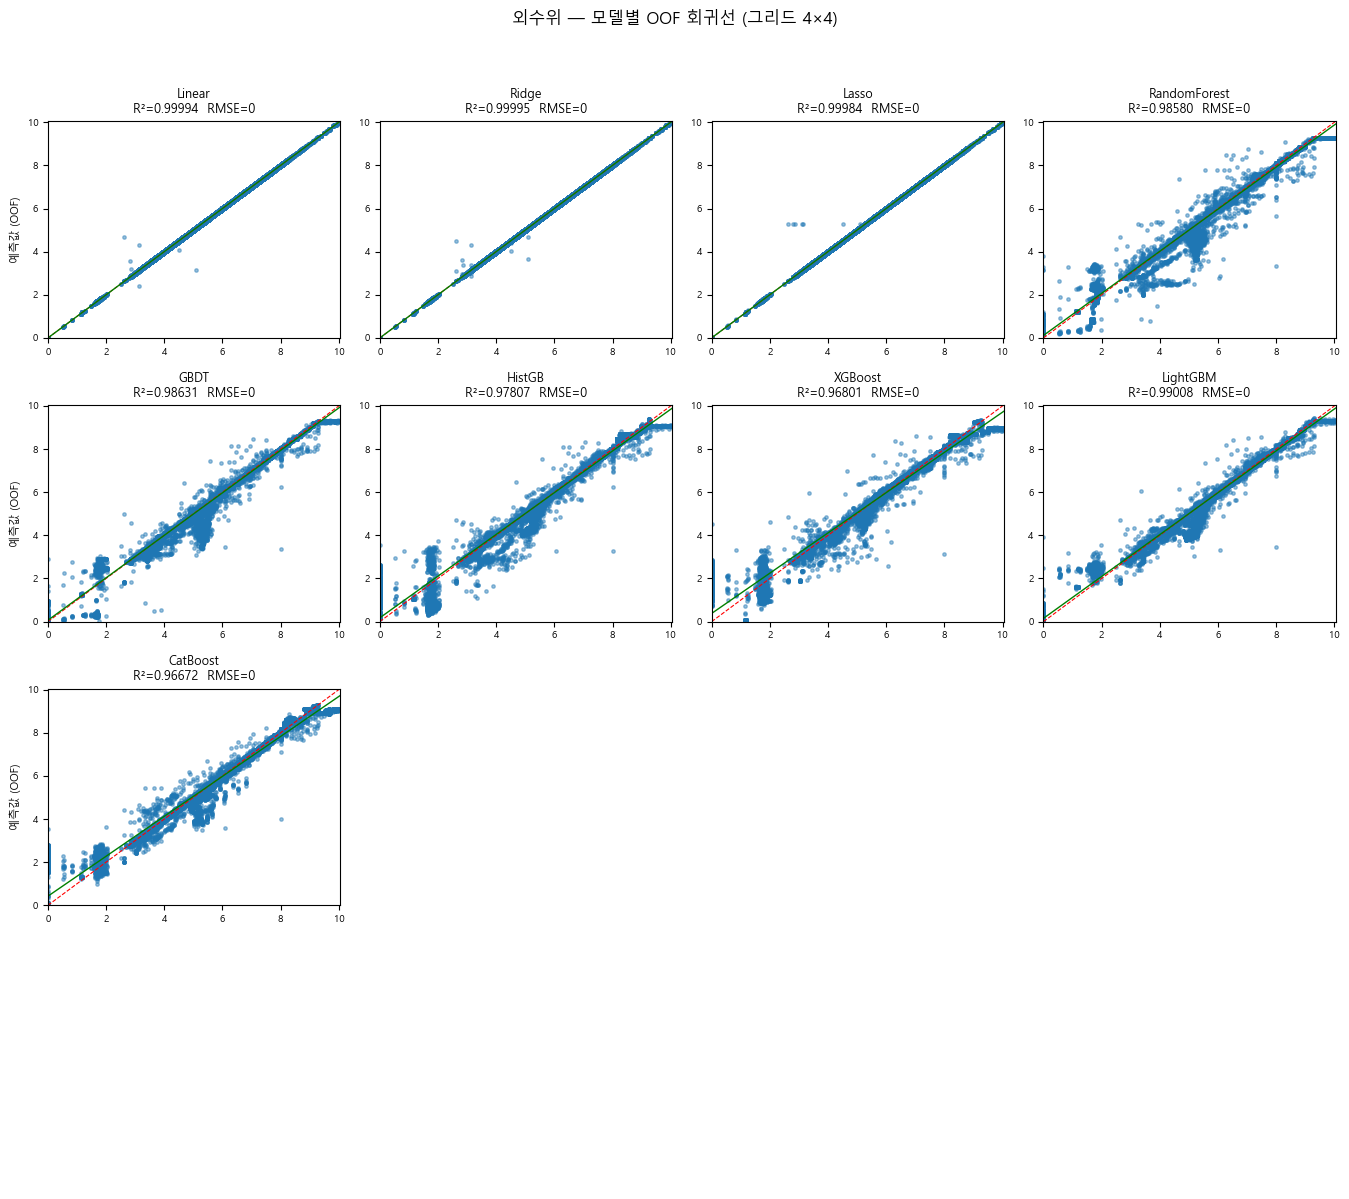


[성능 요약] 외수위
       Model     RMSE       R2
       Ridge 0.011752 0.999951
      Linear 0.013041 0.999939
       Lasso 0.021264 0.999839
    LightGBM 0.166973 0.990078
        GBDT 0.196112 0.986313
RandomForest 0.199760 0.985799
      HistGB 0.248211 0.978075
     XGBoost 0.299802 0.968013
    CatBoost 0.305796 0.966721

[DONE] 타깃별 4x4 OOF 회귀선 그리드 출력(및 저장) 완료.


In [9]:
# -*- coding: utf-8 -*-
# 강서구 펌프장 내/외수위: 데이터 병합 → 전처리/파생 → 4x4 OOF 회귀선 그리드(모델별 성능 한 장 요약)
import os, re, platform, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.base import clone

# =========================
# 사용자 옵션
# =========================
SHOW_PLOTS  = True              # True면 화면에 바로 표시(plt.show)
SAVE_PLOTS  = True              # True면 파일 저장도 수행
OUTDIR      = "figs"            # 저장 폴더
GRID_ROWS   = 4                 # 그리드 행
GRID_COLS   = 4                 # 그리드 열
PANEL_SIZE  = (3.4, 3.0)        # 패널 크기 (inch, 가로,세로)
TARGETS     = ("내수위", "외수위")

# =========================
# 한글 폰트
# =========================
def patch_korean_font():
    sysname = platform.system().lower()
    fonts = (["Malgun Gothic","맑은 고딕"] if "windows" in sysname
             else ["AppleGothic"] if "darwin" in sysname
             else ["NanumGothic","DejaVu Sans"])
    for f in fonts:
        try:
            matplotlib.rcParams["font.family"] = f
            _ = plt.figure(); plt.title("폰트테스트"); plt.close()
            print(f"[INFO] 폰트 적용: {f}")
            break
        except Exception:
            continue
    matplotlib.rcParams["axes.unicode_minus"] = False

patch_korean_font()

# =========================
# 파일 경로 & asof 허용 오차
# =========================
PUMP_FILE  = "1.csv"
HYDRO_FILE = "hydro_raw_2017_2025.csv"
RAIN_FILE  = "rain_2017_2024_merged.csv"
SEWER_FILE = "sewer_2017_2024_merged.csv"
RAIN_TOL, HYDRO_TOL, SEWER_TOL = "1H", "1H", "30min"

# =========================
# 데이터 로드/정규화/병합
# =========================
def load_pump(path=PUMP_FILE):
    pump = pd.read_csv(path)
    if "timestamp" in pump.columns:
        pump["timestamp"] = pd.to_datetime(pump["timestamp"], errors="coerce")
    elif {"일자","시각"} <= set(pump.columns):
        ts_a = pd.to_datetime(pump["일자"], errors="coerce")
        ts_b = pd.to_datetime(pump["시각"], errors="coerce")
        pump["timestamp"] = ts_a.combine_first(ts_b)
    else:
        raise KeyError("펌프 데이터에 'timestamp' 또는 ['일자','시각'] 필요")
    return pump.sort_values("timestamp").reset_index(drop=True)

def load_rain(path=RAIN_FILE):
    rain = pd.read_csv(path)
    if "timestamp" not in rain.columns:
        if "일시" in rain.columns:
            rain["timestamp"] = pd.to_datetime(rain["일시"], errors="coerce")
        else:
            raise KeyError("강우 데이터에 'timestamp' 또는 '일시' 필요")
    else:
        rain["timestamp"] = pd.to_datetime(rain["timestamp"], errors="coerce")
    if "강수량(mm)" in rain.columns:
        rain = rain.rename(columns={"강수량(mm)":"rain_mm"})
    if "rain_mm" not in rain.columns:
        raise KeyError("강우 데이터에 '강수량(mm)' 또는 'rain_mm' 필요")
    rain["rain_mm"] = pd.to_numeric(rain["rain_mm"], errors="coerce")
    return rain[["timestamp","rain_mm"]].dropna(subset=["timestamp"]).sort_values("timestamp")

def load_hydro(path=HYDRO_FILE):
    hydro = pd.read_csv(path)
    if "관측 일시" not in hydro.columns: raise KeyError("수문 데이터에 '관측 일시' 필요")
    date_col = "관측 일시"
    hour_cols = [c for c in hydro.columns if re.fullmatch(r"\s*\d{1,2}시\s*", str(c))]
    if not hour_cols: raise KeyError("'01시'~'24시' 시간 컬럼 없음")
    long = hydro.melt(id_vars=[date_col], value_vars=hour_cols,
                      var_name="hour_k", value_name="hydro_value")
    long[date_col] = pd.to_datetime(long[date_col], errors="coerce").dt.floor("D")
    long["hour_num"] = long["hour_k"].astype(str).str.extract(r"(\d{1,2})").astype(int)
    # 1~24시 → 0~23시
    long["timestamp"] = long[date_col] + pd.to_timedelta((long["hour_num"]-1) % 24, unit="h")
    long["hydro_value"] = pd.to_numeric(long["hydro_value"], errors="coerce")
    agg = (long.dropna(subset=["timestamp"])
                .groupby("timestamp", as_index=False)["hydro_value"].mean())
    return agg.sort_values("timestamp")

def load_sewer(path=SEWER_FILE):
    sewer = pd.read_csv(path)
    if not {"timestamp","water_level"} <= set(sewer.columns):
        raise KeyError("하수 데이터에 'timestamp','water_level' 필요")
    sewer["timestamp"] = pd.to_datetime(sewer["timestamp"], errors="coerce")
    sewer["water_level"] = pd.to_numeric(sewer["water_level"], errors="coerce")
    agg = sewer.groupby("timestamp", as_index=False)["water_level"].mean()
    return agg.sort_values("timestamp")

def merge_asof_(left, right, tol):
    if right is None or len(right)==0: return left
    return pd.merge_asof(left.sort_values("timestamp"),
                         right.sort_values("timestamp"),
                         on="timestamp", direction="backward",
                         tolerance=pd.Timedelta(tol))

# 병합
pump, rain, hydro, sewer = load_pump(), load_rain(), load_hydro(), load_sewer()
df = pump.copy()
df = merge_asof_(df, rain,  RAIN_TOL)
df = merge_asof_(df, hydro, HYDRO_TOL)
df = merge_asof_(df, sewer, SEWER_TOL)

# 결측 보정(수치형: ffill→bfill→median)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].ffill().bfill()
for c in num_cols: df[c] = df[c].fillna(df[c].median())

# =========================
# 시계열 파생(펌프장명 그룹)
# =========================
def add_time_features(_df, group_col="펌프장명",
                      base=("rain_mm","hydro_value","water_level","내수위","외수위")):
    d = _df.copy()
    if group_col in d.columns:
        d = d.sort_values([group_col,"timestamp"])
        g = d.groupby(group_col, group_keys=False)
        def rmean(gser, w): return gser.rolling(w).mean().reset_index(level=0, drop=True)
        for col in base:
            if col in d.columns and pd.api.types.is_numeric_dtype(d[col]):
                d[f"{col}_lag1"]  = g[col].shift(1)
                d[f"{col}_lag2"]  = g[col].shift(2)
                d[f"{col}_diff1"] = g[col].diff()
                d[f"{col}_rm3"]   = rmean(g[col], 3)
                d[f"{col}_rm6"]   = rmean(g[col], 6)
    else:
        d = d.sort_values("timestamp")
        for col in base:
            if col in d.columns and pd.api.types.is_numeric_dtype(d[col]):
                d[f"{col}_lag1"]  = d[col].shift(1)
                d[f"{col}_lag2"]  = d[col].shift(2)
                d[f"{col}_diff1"] = d[col].diff()
                d[f"{col}_rm3"]   = d[col].rolling(3).mean()
                d[f"{col}_rm6"]   = d[col].rolling(6).mean()
    for c in d.select_dtypes(include=[np.number]).columns:
        d[c] = d[c].fillna(d[c].median())
    return d

df = add_time_features(df)

# =========================
# 모델 레지스트리 (최대 16개까지 4x4에 배치)
# =========================
def build_models():
    models = {
        "Linear": Pipeline([("sc", StandardScaler()), ("m", LinearRegression())]),
        "Ridge":  Pipeline([("sc", StandardScaler()), ("m", Ridge(alpha=1.0))]),
        "Lasso":  Pipeline([("sc", StandardScaler()), ("m", Lasso(alpha=1e-3, max_iter=10000))]),
        "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
        "GBDT": GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42),
        "HistGB": HistGradientBoostingRegressor(max_iter=500, learning_rate=0.05, max_depth=6, random_state=42),
    }
    # 옵션 부스팅(설치 시 자동 포함)
    try:
        from xgboost import XGBRegressor
        models["XGBoost"] = XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, tree_method="hist"
        )
    except Exception as e:
        print("[INFO] XGBoost 스킵:", e)
    try:
        from lightgbm import LGBMRegressor
        models["LightGBM"] = LGBMRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=-1,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
        )
    except Exception as e:
        print("[INFO] LightGBM 스킵:", e)
    try:
        from catboost import CatBoostRegressor
        models["CatBoost"] = CatBoostRegressor(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, loss_function="RMSE", verbose=False
        )
    except Exception as e:
        print("[INFO] CatBoost 스킵:", e)
    return models

# =========================
# 4x4 OOF 회귀선 그리드
# =========================
def oof_grid_4x4(
    df, target, group_col="펌프장명",
    drop_cols=("timestamp","일자","시각","펌프장 주소","위도","경도","데이터기준일자"),
    rows=4, cols=4, panel_size=(3.4,3.0),
    show=True, savepath=None
):
    models = build_models()
    items = list(models.items())
    max_panels = rows * cols
    items = items[:max_panels]  # 4x4=16개 초과 시 앞에서 16개만 사용

    # 피처/타깃
    feats = [c for c in df.columns if c not in set(drop_cols)|{target} and df[c].dtype != "O"]
    X = df[feats].copy(); y = df[target].copy()
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]

    # 동일 분할(공정 비교)
    if group_col in df.columns:
        base_splits = list(GroupKFold(n_splits=5).split(X, y, groups=df.loc[X.index, group_col]))
    else:
        base_splits = list(KFold(n_splits=5, shuffle=True, random_state=42).split(X))

    # 고정 축 범위(시각 스케일 통일)
    y_min, y_max = float(y.min()), float(y.max())

    # 그리드 캔버스
    fig, axes = plt.subplots(rows, cols, figsize=(cols*panel_size[0], rows*panel_size[1]), squeeze=False)

    summary = []
    for i in range(rows*cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]

        if i >= len(items):
            ax.axis("off")
            continue

        name, base_model = items[i]

        # OOF 예측
        oof = np.zeros(len(y), dtype=float)
        for tr_idx, va_idx in base_splits:
            m = clone(base_model) if hasattr(base_model, "get_params") else base_model
            m.fit(X.iloc[tr_idx], y.iloc[tr_idx])
            oof[va_idx] = m.predict(X.iloc[va_idx])

        rmse = float(np.sqrt(mean_squared_error(y, oof)))
        r2v  = float(r2_score(y, oof))

        summary.append([name, rmse, r2v])

        # 산점도 + y=x + 회귀선
        ax.scatter(y, oof, s=6, alpha=0.45)
        ax.plot([y_min, y_max], [y_min, y_max], "r--", lw=0.8)
        k = np.polyfit(y, oof, 1)
        xx = np.linspace(y_min, y_max, 60)
        ax.plot(xx, k[0]*xx + k[1], "g-", lw=1.0)

        ax.set_xlim(y_min, y_max); ax.set_ylim(y_min, y_max)
        ax.tick_params(labelsize=7)
        ax.set_title(f"{name}\nR²={r2v:.5f}  RMSE={rmse:,.0f}", fontsize=9)

        if c == 0: ax.set_ylabel("예측값 (OOF)", fontsize=8)
        if r == rows-1: ax.set_xlabel(f"실제값 ({target})", fontsize=8)

    fig.suptitle(f"{target} — 모델별 OOF 회귀선 (그리드 {rows}×{cols})", fontsize=12, y=0.995)
    fig.tight_layout(rect=[0,0,1,0.97])

    if SAVE_PLOTS and savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, dpi=220, bbox_inches="tight")
        print(f"[INFO] 저장: {savepath}")
    if show:
        plt.show()
    plt.close(fig)

    # 성능 요약 반환(터미널에 표 출력)
    res_df = pd.DataFrame(summary, columns=["Model","RMSE","R2"]).sort_values(["R2","RMSE"], ascending=[False, True])
    print("\n[성능 요약]", target)
    print(res_df.to_string(index=False))
    return res_df

# =========================
# 실행: 타깃별 4x4 한 장씩 생성
# =========================
available_targets = [t for t in TARGETS if t in df.columns]
if not available_targets:
    raise ValueError("내수위/외수위 타깃 컬럼을 찾을 수 없습니다.")

if SAVE_PLOTS:
    os.makedirs(OUTDIR, exist_ok=True)

for tgt in available_targets:
    savepath = os.path.join(OUTDIR, f"{tgt}_OOF_grid_{GRID_ROWS}x{GRID_COLS}.png") if SAVE_PLOTS else None
    oof_grid_4x4(
        df, target=tgt, rows=GRID_ROWS, cols=GRID_COLS,
        panel_size=PANEL_SIZE, show=SHOW_PLOTS, savepath=savepath
    )

print("\n[DONE] 타깃별 4x4 OOF 회귀선 그리드 출력(및 저장) 완료.")
